In [ ]:
#!python --version

In [ ]:
!python3   -m pip install SomePackage  # default Python 3

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (18.1)


In [ ]:
#!apt-get install python3-pip

In [1]:
# http://pytorch.org 파이토치 설치/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
!apt-get update

!apt-get install g++ openjdk-8-jdk python-dev python3-dev

!pip3 install JPype1-py3

!pip3 install konlpy

!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
  Using cached https://files.pythonhosted.org/packages/59/90/149647ac2c8649a5983fcc47c78f2881af80cbd99f54248ac31b3d611618/JPype1-py3-0.5.5.2.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "/tmp/pip-install-m6i7kqxp/JPype1-py3/setup.py", line 454, in <module>
        config = LinuxJDKFinder()
      File "/tmp/pip-install-m6i7kqxp/JPype1-py3/setup.py", line 402, in __init__
        java_home = self.find_jdk_home()
      File "/tmp/pip-install-m6i7kqxp/JPype1-py3/setup.py", line 442, in find_jdk_home
        raise NoJDKError(visited_folders)
    __main__.NoJDKError: No JDK found
    
    During handling of the above exception, another exception occ

In [58]:
from __future__ import unicode_literals, print_function, division
from io import open

import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import numpy as np

import konlpy
from konlpy.tag import Hannanum, Okt, Kkma
from konlpy.utils import pprint
Hannanum = Hannanum()
Okt = Okt()

use_cuda = torch.cuda.is_available()

In [59]:
Kkma = Kkma()
pprint(Kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))
sentence=u'네, 안녕하세요. 반갑습니다.'
words = konlpy.tag.Kkma().pos(sentence)
pprint(words)

['네, 안녕하세요.', '반갑습니다.']
[('네', 'MDN'),
 (',', 'SP'),
 ('안녕', 'NNG'),
 ('하', 'XSV'),
 ('세요', 'EFN'),
 ('.', 'SF'),
 ('반갑', 'VV'),
 ('습니다', 'EFN'),
 ('.', 'SF')]


In [60]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  #  SOS 와 EOS 단어 숫자 포함

    def addSentence(self, sentence):
        for word in Okt.morphs(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [61]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# http://stackoverflow.com/a/518232/2809427 에 감사드립니다.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거

# 한글 문자열 노머라이징 
def normalizeString1(s):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣 ^☆; ^a-zA-Z.!?]+')
    result = hangul.sub('', s)
    return result

def normalizeString2(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [62]:
def readText():
    print("Reading lines...")

    # Read the file and split into lines
    inputs = open('kor110000.txt', encoding = 'utf-8').read().strip().split("\n")
    outputs = open('eng110000.txt', encoding = 'utf-8').read().strip().split("\n")

    # 모든 줄을 쌍으로 분리하고 정규화 하십시오
    inputs = [s for s in inputs]
    outputs = [s for s in outputs]
    print(len(inputs))
    print(len(outputs))    
    inp = Lang('input')
    outp = Lang('output')
    
    pair = []
    for i in range(len(inputs)):
      pair.append([inputs[i], outputs[i]])
        
    return inp, outp, pair
   #input과 output을 갖는 pair라는 리스트를 생성한다.


In [63]:
MAX_LENGTH = 80
MAX_word = 9

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_word and \
        len(p[1].split(' ')) < MAX_word
#        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [64]:
def prepareData():
    input_lang, output_lang, pairs = readText()
    
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData()
print(random.choice(pairs))
#words1 = Hannanum.morphs(random.choice(pairs[0]))
#words2 = Hannanum.morphs(random.choice(pairs[1]))
#b = np.array(words1)
#pprint(b.T)
#pprint(words1)
#pprint(words2)

Reading lines...
111192
111192
Read 111192 sentence pairs
Trimmed to 77663 sentence pairs
Counting words...
Counted words:
input 28481
output 22200
['아이를 타일러서 학교에 보내다.', 'Get the child to go to school.']


In [42]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [43]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [44]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [45]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in Okt.morphs(sentence)] 


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [46]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # teacher forcing 없이: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

이것은 현재 시간과 진행률%을 고려하여 경과된 시간과 남은 예상
시간을 출력하는 헬퍼 함수입니다.




In [47]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [48]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # 매 print_every 마다 초기화
    plot_loss_total = 0   # 매 plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [50]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[topi.item()])
            #decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [51]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [52]:

hidden_size = 256 
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

KeyboardInterrupt: 

In [19]:
evaluateRandomly(encoder1, attn_decoder1)

> 우리가 5점 앞선다.
= We are five points ahead.
< We ' re a . . . . . <EOS>

> 장애물 때문에 지나갈 수가 없었어요. 
= I couldn't get by because of the obstacle.
< I can ' t get . . . . <EOS>

> 이런 공장이 하천을 따라 우후죽순처럼 건설되기 시작하였다.
= Factories of this sort mushroomed along the river.
< The rain began out the the the . . <EOS>

> 부탁이 있는데 괜찮아요?
= Would you do me a favor?
< Is you please this ? <EOS>

> 우리 먼저 지난 과를 복습하는 것부터 시작하자.
= Let's begin by reviewing the last lesson.
< Let ' s go to to a . <EOS>

> 그는 가난으로 인해 배고픔을 참는데 익숙해졌다.
= Poverty conditioned him to hunger.
< He was himself with his . . . <EOS>

> 협조해주서 감사해요.
= I appreciate your cooperation.
< The ' s . . . . <EOS>

> 아이를 방해하지 말아라.
= Don't disturb the baby.
< Don ' t be out of children . <EOS>

> 그들은 줄곧 심야까지 노동했다.
= They laboured on far into the night.
< They arrived on to the . . . . <EOS>

> 여러분 앞에서 공연하게 되어 저는 매우 영광입니다.
= I have the honor,honour) of performing before you all.
< I ' m a at the the . . . <EOS>



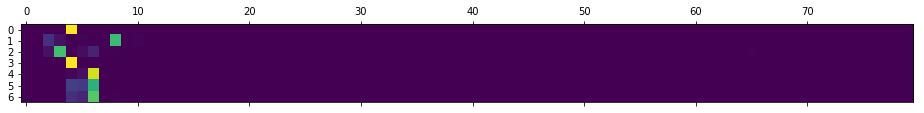

In [20]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "그녀는 상식이 풍부하다.")
plt.matshow(attentions.numpy())

input = 여자친구에게 말해줘
output = Tell me a doctor <EOS>


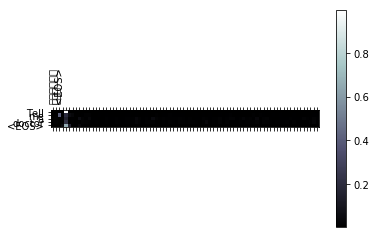

input = 같이 가자
output = Let ' s go to go to <EOS>


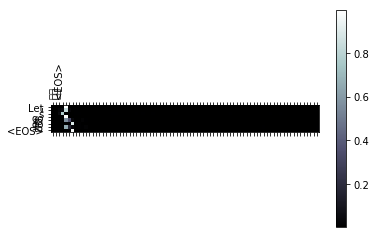

input = 안녕
output = It <EOS>


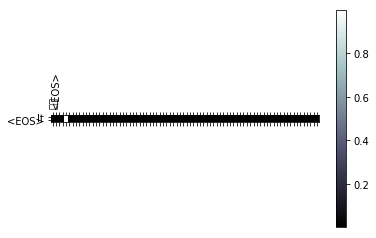

input = 교수님이 뭐라고 하셨어?
output = Have you a ? ? <EOS>


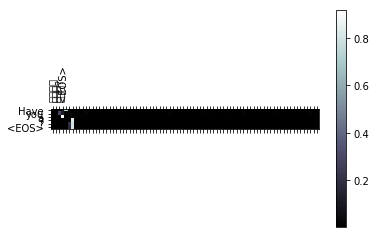

input = 나랑 학교가자.
output = I ' m to go . . . <EOS>


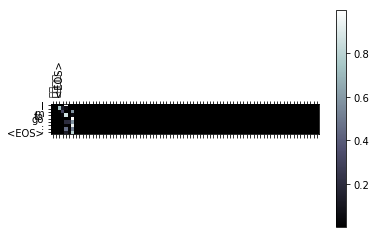

input = 몇시간 걸려?
output = What time do you ? ? <EOS>


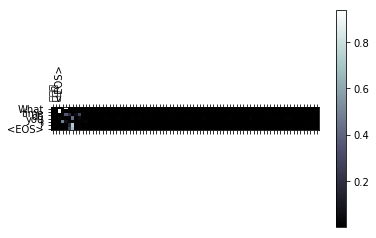

input = 밥 먹자
output = I ' m <EOS>


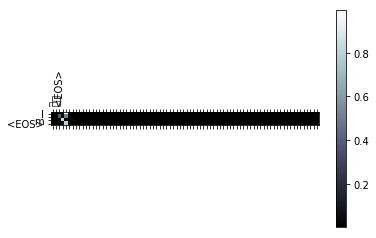

input = 밥 먹을래?
output = Do you like ? <EOS>


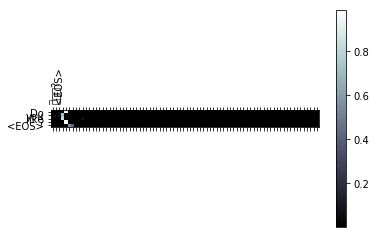

input = 바보
output = You ' <EOS>


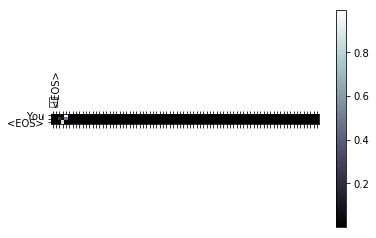

input = 밥 먹었어?
output = Do you have ? <EOS>


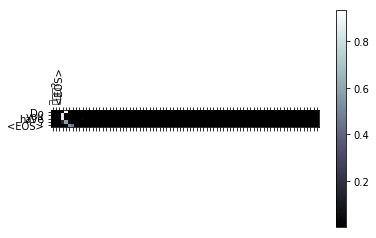

KeyError: '먹었냐'

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("여자친구에게 말해줘")

evaluateAndShowAttention("같이 가자")

evaluateAndShowAttention("안녕")

evaluateAndShowAttention("교수님이 뭐라고 하셨어?")

evaluateAndShowAttention("나랑 학교가자.")

evaluateAndShowAttention("몇시간 걸려?")
evaluateAndShowAttention("밥 먹자")
evaluateAndShowAttention("밥 먹을래?")
#evaluateAndShowAttention("학식 뭐야?")
evaluateAndShowAttention("바보")
evaluateAndShowAttention("밥 먹었어?")
#evaluateAndShowAttention("밥 사줘")
#evaluateAndShowAttention("밥 묵자")
evaluateAndShowAttention("밥 먹었냐?")
evaluateAndShowAttention("밥 사와")

input = 밥 먹으러 가자
output = Do you a <EOS>


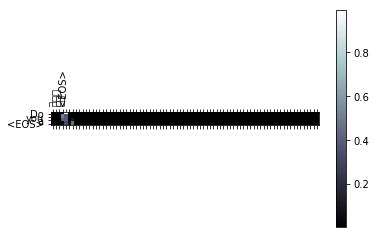

input = 밥
output = I ' <EOS>


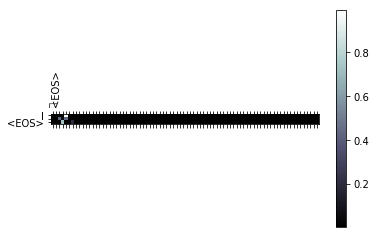

input = 나 너 알아
output = You ' s you me <EOS>


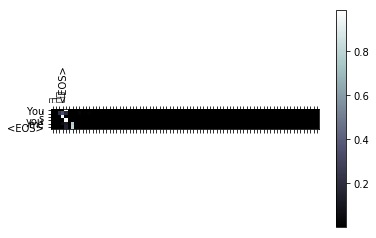

input = 귤 좋아해?
output = How you have ? ? ? <EOS>


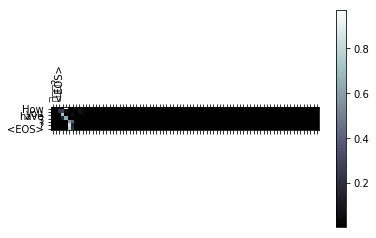

input = 저녁밥 먹자
output = It ' s a . <EOS>


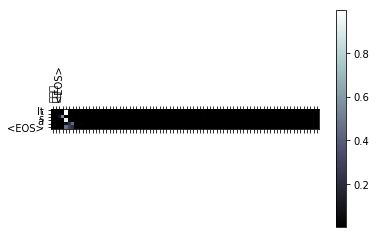

In [35]:
evaluateAndShowAttention("밥 먹으러 가자")
evaluateAndShowAttention("밥")
evaluateAndShowAttention("나 너 알아")
evaluateAndShowAttention("귤 좋아해?")
evaluateAndShowAttention("저녁밥 먹자")

In [22]:
import os
print (os.getcwd())

/home/jovyan/work


In [23]:
torch.save('/home/jovyan/work/attention(1)-Copy2','/home/jovyan/work/‪model80000max10.pd')